In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:77% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [46]:
import os
import re
import time
import pickle
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from collections import OrderedDict
from net.st_gcn import Model
from feeder.feeder import Feeder
from torchlight.io import IO
from ad_utils import map2ind, loader_initializer
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=100, precision=5, suppress=True)

In [3]:
# Loading of original weights
data_dir_path = '/root/sharedfolder/datasets/data_ssd/kinetics-skeleton/st-gcn_kinetics/Kinetics/kinetics-skeleton/'
root_path = '/root/sharedfolder/Research/pose_ad/st-gcn/'
weights_path =  os.path.join(root_path, 'models/kinetics-st_gcn.pt')
ft_weights_path = os.path.join(root_path, 'models/kinetics-st_gcn_ft.pt')
io = IO(root_path)
model_name = 'net.st_gcn.Model'
graph_args = {'layout':'openpose', 'strategy':'spatial'}
model_args = {
    'edge_importance_weighting':True,
    'graph_args':graph_args,
    'in_channels':3,
    'num_class':4, }

In [4]:
model = io.load_model(model_name, **model_args)

In [5]:
# Need to turn into a func
weights = torch.load(weights_path)
weights_list = [[k.split('module.')[-1], v.cpu()] for k, v in weights.items()]
weights = OrderedDict(weights_list)
model_state_dict = model.state_dict()
weights.pop('fcn.bias') # loading all but the Final FC layer's weight and bias
weights.pop('fcn.weight')
model_state_dict.update(weights)
model.load_state_dict(model_state_dict)

In [6]:
# Freezing of layers for fine tuning
for name, param in model.named_parameters():
    param.requires_grad = False
    if "fcn" in name:  # Keeping the last FC layer trainable
        param.requires_grad = True
#     if name.find('9') != -1:  # For adding an additional graph conv layer to the training
#         param.requires_grad = True
    print (name, param.requires_grad) 

data_bn.weight False
data_bn.bias False
st_gcn_networks.0.gcn.conv.weight False
st_gcn_networks.0.gcn.conv.bias False
st_gcn_networks.0.tcn.0.weight False
st_gcn_networks.0.tcn.0.bias False
st_gcn_networks.0.tcn.2.weight False
st_gcn_networks.0.tcn.2.bias False
st_gcn_networks.0.tcn.3.weight False
st_gcn_networks.0.tcn.3.bias False
st_gcn_networks.1.gcn.conv.weight False
st_gcn_networks.1.gcn.conv.bias False
st_gcn_networks.1.tcn.0.weight False
st_gcn_networks.1.tcn.0.bias False
st_gcn_networks.1.tcn.2.weight False
st_gcn_networks.1.tcn.2.bias False
st_gcn_networks.1.tcn.3.weight False
st_gcn_networks.1.tcn.3.bias False
st_gcn_networks.2.gcn.conv.weight False
st_gcn_networks.2.gcn.conv.bias False
st_gcn_networks.2.tcn.0.weight False
st_gcn_networks.2.tcn.0.bias False
st_gcn_networks.2.tcn.2.weight False
st_gcn_networks.2.tcn.2.bias False
st_gcn_networks.2.tcn.3.weight False
st_gcn_networks.2.tcn.3.bias False
st_gcn_networks.3.gcn.conv.weight False
st_gcn_networks.3.gcn.conv.bias False


In [7]:
data_path   = dict()
label_path  = dict()
data_loader = dict()
feeder_args = dict()

In [8]:
train_data_path = os.path.join(data_dir_path, 'train_data.npy')
train_label_path = os.path.join(data_dir_path, 'train_label.pkl')
test_data_path = os.path.join(data_dir_path, 'val_data.npy')
test_label_path = os.path.join(data_dir_path, 'val_label.pkl')

In [9]:
normal_classes = [30, 74, 22, 15]
sample_a = [59, 88, 134, 254]
for split in ['normal_train', 'normal_test', 'mixed_test']:
    data_path[split]   =  os.path.join(data_dir_path, 'ad_experiment', split+'_data.npy')
    label_path[split]  =  os.path.join(data_dir_path, 'ad_experiment', split+'_label.pkl')
    feeder_args[split] = {'data_path': data_path[split], 'label_path': label_path[split]}
    
feeder_args['random_train'] = {'data_path': train_data_path, 'label_path': train_label_path, 'specify_classes':normal_classes}
feeder_args['random_test'] = {'data_path': test_data_path, 'label_path': test_label_path}  #, 'specify_classes':normal_classes}

In [10]:
batch_size=32
data_loader['normal_train'] = loader_initializer(feeder_args['normal_train'], batch_size=batch_size)
data_loader['normal_test' ] = loader_initializer(feeder_args['normal_test' ], batch_size=batch_size, drop_last=False)
data_loader['mixed_test'  ] = loader_initializer(feeder_args['mixed_test'  ], batch_size=batch_size, suffle=False, drop_last=False)

data_loader['random_train' ] = loader_initializer(feeder_args['random_train' ], batch_size=batch_size, drop_last=True)
data_loader['random_test'  ] = loader_initializer(feeder_args['random_test'  ], batch_size=batch_size, suffle=False, drop_last=False)

In [11]:
# Model Definitions for Training
dev = 'cuda:0'
model = model.to(dev)
loss_fn = nn.CrossEntropyLoss()
# loader = data_loader['normal_train']
loader = data_loader['random_train']
loss_th = 0.15

In [12]:
optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

In [13]:
model_filename = 'models/kinetics-nc{}_curr.pt'.format(len(normal_classes))
curr_weights_path = os.path.join(root_path, model_filename)

In [15]:
# Training Loop
train = 0 # 0 - Not, 1 - Train only, 2 - Train and Save

if train >= 1:
    for epoch in range(3):
        for itern, [data, label] in enumerate(loader):
                # get data
                data = data.float().to(dev)
                label = torch.from_numpy(map2ind(label))
                label = label.long().to(dev)

                # forward
                output = model(data)
                loss = loss_fn(output, label)

                # backward
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if itern%10 == 0: 
                    print("Iteration {} (Epoch: {}), loss is {}".format(itern, epoch, loss))
                if loss < loss_th:
                    print("Met loss {} in Epoch {}, iteration {}".format(loss, epoch, itern))
                    break
        else:
            continue
        break
    print("Done")
if train == 2:
    torch.save(model.state_dict(), curr_weights_path)

In [16]:
# For output evaluation
if train >= 1:
    sfmax_vals, cls = torch.max(output, 1)
    print("Correct predictions\n {}".format(cls==label))
    softmax = nn.Softmax(dim=1)
    osoftmax_gpu = softmax(output)

    sfmax_vals, cls = torch.max(osoftmax_gpu, 1)

    osoftmax = 100 * osoftmax_gpu.cpu().detach().numpy()
    print("Softmax Outputs \n{} \nSofmax max values \n{}".format(osoftmax, sfmax_vals))
    torch.mean(sfmax_vals)

In [17]:
dev = 'cuda:0'
model_ld = io.load_model(model_name, **model_args)
model_ld.load_state_dict(torch.load(curr_weights_path))
model_ld.to(dev)
model_ld.eval()

Model(
  (data_bn): BatchNorm1d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (st_gcn_networks): ModuleList(
    (0): st_gcn(
      (gcn): ConvTemporalGraphical(
        (conv): Conv2d(3, 192, kernel_size=(1, 1), stride=(1, 1))
      )
      (tcn): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Dropout(p=0, inplace)
      )
      (relu): ReLU(inplace)
    )
    (1): st_gcn(
      (gcn): ConvTemporalGraphical(
        (conv): Conv2d(64, 192, kernel_size=(1, 1), stride=(1, 1))
      )
      (tcn): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4

In [ ]:
# Model Definitions for Testing
# loader = data_loader['mixed_test']
loader = data_loader['random_test']
model = model_ld

In [27]:
loss_value = []
result_frag = []
label_frag = []
label_ad = np.empty(0)
outputs = []
epoch_info = dict()
confusion_mat = np.zeros([5,5], dtype=np.int32)
evaluation = True
softmax = nn.Softmax(dim=1)

for itern, [data, label_ld] in enumerate(loader):
    # get data
    data = data.float().cuda()
    label_ad_curr = map2ind(label_ld, from_arr=normal_classes, to_arr=np.ones_like(normal_classes), def_val=0)
    label_ad = np.concatenate((label_ad, label_ad_curr))
    label_mapped = map2ind(label_ld, from_arr=normal_classes, to_arr=None, def_val=0) # Assign output probs regardless of abnormal classes,
    label = torch.from_numpy(label_mapped)
    
    label = label.long().cuda()

    # inference
    with torch.no_grad():
        output = model(data)
    result_frag.append(output.data.cpu().numpy())

    # get loss
    if evaluation:
        loss = loss_fn(output, label)
        confusion_mat[label_mapped, np.argmax(output, axis=1)] += 1
        loss_value.append(loss.data[0])
        label_frag.append(label.data.cpu().numpy())
        outputs.append([itern ,softmax(output).data.cpu().numpy()])
        
    # Track progress
    if itern % 50 == 0:
        print("Iteration {}".format(itern))

result = np.concatenate(result_frag)
# np.savetxt("kinetics400_confusion.csv", confusion_mat)
if evaluation:
    label2 = np.concatenate(label_frag)
    epoch_info['mean_loss'] = np.mean(loss_value)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:30: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration 0
Iteration 50
Iteration 100
Iteration 150
Iteration 200
Iteration 250
Iteration 300
Iteration 350
Iteration 400
Iteration 450
Iteration 500
Iteration 550
Iteration 600


In [29]:
label_ad.shape

(19796,)

In [31]:
len(outputs)
out_sfmax = [np.array(sf) for i, sf in outputs]
out_sfmax = np.concatenate(out_sfmax, axis=0)
out_sfmax_max_vals = out_sfmax.max(axis=1)
split_idx = 198
normal_max_sfmax = out_sfmax_max_vals[label_ad == 1]
abnormal_max_sfmax = out_sfmax_max_vals[label_ad == 0]
print(normal_max_sfmax.mean(), abnormal_max_sfmax.mean())

0.8086166 0.68350524


In [ ]:
# For output evaluation
sfmax_vals, cls = torch.max(output, 1)
print("Correct predictions\n {}".format(cls==label))
softmax = nn.Softmax(dim=1)
osoftmax_gpu = softmax(output)

sfmax_vals, cls = torch.max(osoftmax_gpu, 1)

osoftmax = 100 * osoftmax_gpu.cpu().detach().numpy()
print("Softmax Outputs \n{} \nSofmax max values \n{}".format(osoftmax, sfmax_vals))
torch.mean(sfmax_vals)
label
# print("Correct predictions\n {}".format(cls_bn==label))


In [33]:
from sklearn.metrics import roc_curve, auc

true_labels = label_ad
fpr, tpr, thresholds = roc_curve(true_labels, out_sfmax_max_vals)
roc_auc = auc(fpr, tpr)

roc_auc

0.7035034846631998

In [56]:
# Log To Text File
log_str = "Results for classes {}\nfpr: {}\ntpr: {}\nthr: {}".format(normal_classes, fpr[::20], tpr[::20], thresholds[::20])
# print(log_str)
normal_classes_str = [str(i) for i in normal_classes]
classes_str = '_'.join(normal_classes_str)
time_str = time.strftime("%b%d_%H%M")
log_filename = "{}_{}_auc{}.txt".format(time_str, classes_str, str(int(100*roc_auc)))
log_dirname = 'logs/kinetics_trained_n_v_all/'
logfile_path = os.path.join(root_path, log_dirname, log_filename)
with open(logfile_path, 'w') as f:
    f.write(log_str)

In [34]:
ind=95
print(tpr[ind], fpr[ind], thresholds[ind])

0.25125628140703515 0.047507271521151195 0.9535472


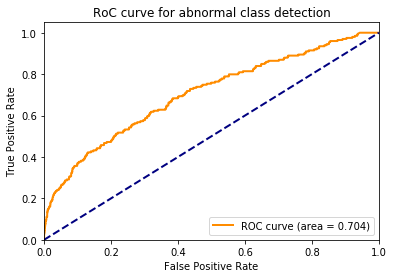

In [35]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RoC curve for abnormal class detection')
plt.legend(loc="lower right")
plt.show()